In [1]:
from accelerate import Accelerator

from dataclasses import dataclass, field
from typing import Optional
import torch
from datasets import load_dataset
from tqdm import tqdm
from transformers import AutoTokenizer, pipeline, HfArgumentParser, Adafactor

from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler

DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
tqdm.pandas()

/home/edward/work/trl/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


In [2]:
train_dataset = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/rl", split="train")
train_dataset = train_dataset.select(range(10000))
sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 16}


Using custom data configuration lvwerra--stack-exchange-paired-e5ccc5f74f1da5b7
Found cached dataset parquet (/home/edward/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-e5ccc5f74f1da5b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [3]:
def build_dataset(tokenizer, dataset_name="lvwerra/stack-exchange-paired"):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    # load imdb with datasets
    ds = load_dataset(dataset_name, data_dir="data/rl", split="train")
    original_columns = ds.column_names
    num_proc = 12

    def preprocess_function(examples):
        new_examples = {
            "question": [],
            "text_j": [],
            "text_k": [],
            "response_j": [],
            "response_k": [],
        }
        for question, response_j, response_k in zip(
            examples["question"], examples["response_j"], examples["response_k"]
        ):
            question = "Question: " + question + "\n\nAnswer: "
            text_j = "Question: " + question + "\n\nAnswer: " + response_j
            text_k = "Question: " + question + "\n\nAnswer: " + response_k

            new_examples["question"].append(question)
            new_examples["text_j"].append(text_j)
            new_examples["text_k"].append(text_k)
            new_examples["response_j"].append(response_j)
            new_examples["response_k"].append(response_k)

        return new_examples

    ds = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_proc,
        remove_columns=original_columns,
    )
    ds = ds.filter(lambda x: len(x["text_j"]) < 512 and len(x["text_k"]) < 512, batched=False)

    ds.set_format(type="torch")
    return ds

In [4]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

# We retrieve the dataloader by calling the `build_dataset` function.
dataset = build_dataset(None)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    collate_fn=collator,
    shuffle=True,
    drop_last=True,
)

Using custom data configuration lvwerra--stack-exchange-paired-e5ccc5f74f1da5b7
Found cached dataset parquet (/home/edward/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-e5ccc5f74f1da5b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/edward/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-e5ccc5f74f1da5b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-d855e946bac97646.arrow
Loading cached processed dataset at /home/edward/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-e5ccc5f74f1da5b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-161be236cc45ee87.arrow
Loading cached processed dataset at /home/edward/.cache/huggingface/datasets/lvwerra___parquet/lvwerra--stack-exchange-paired-e5ccc5f74f1da5b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-53ff3

In [5]:

llama_tokenizer = AutoTokenizer.from_pretrained("huggingface/llama-7b")
llama_tokenizer.add_special_tokens(
        {
            "eos_token": DEFAULT_EOS_TOKEN,
            "bos_token": DEFAULT_BOS_TOKEN,
            "unk_token": DEFAULT_UNK_TOKEN,
            "pad_token": DEFAULT_PAD_TOKEN,
        }
    )

sentiment_pipe_llama_rm = pipeline(
    "sentiment-analysis",
    model="kashif/llama-7b_stack-exchange_RM_peft-adapter-merged",
    device_map="auto",
    model_kwargs={"load_in_8bit": True},
    tokenizer=llama_tokenizer,
)


gpt2_tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-xl-stackexchange")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
sentiment_pipe_gpt2_xl_rm = pipeline(
    "sentiment-analysis",
    model="edbeeching/gpt2-xl-stackexchange_stack-exchange-paired_rmts_240000_bup",
    device_map="auto",
    model_kwargs={"load_in_8bit": True},
    tokenizer=gpt2_tokenizer,
)

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]
Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


In [6]:
llama_rewards_js = []
llama_rewards_ks = []

gpt2_rewards_js = []
gpt2_rewards_ks = []

for epoch, batch in tqdm(enumerate(dataloader)):
    if epoch >= 20:
        break
    texts_j = batch["text_j"]
    texts_k = batch["text_k"]

    llama_pipe_outputs_j = sentiment_pipe_llama_rm(texts_j, **sent_kwargs)
    llama_pipe_outputs_k = sentiment_pipe_llama_rm(texts_k, **sent_kwargs)
    llama_rewards_j = [output[0]["score"] for output in llama_pipe_outputs_j]
    llama_rewards_k = [output[0]["score"] for output in llama_pipe_outputs_k]
    llama_rewards_js.extend(llama_rewards_j)
    llama_rewards_ks.extend(llama_rewards_k)


    gpt2_pipe_outputs_j = sentiment_pipe_gpt2_xl_rm(texts_j, **sent_kwargs)
    gpt2_pipe_outputs_k = sentiment_pipe_gpt2_xl_rm(texts_k, **sent_kwargs)
    gpt2_rewards_j = [output[0]["score"] for output in gpt2_pipe_outputs_j]
    gpt2_rewards_k = [output[0]["score"] for output in gpt2_pipe_outputs_k]
    gpt2_rewards_js.extend(gpt2_rewards_j)
    gpt2_rewards_ks.extend(gpt2_rewards_k)

0it [00:00, ?it/s]/home/edward/work/trl/venv/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/home/edward/work/trl/venv/lib/python3.8/site-packages/transformers/models/gpt2/modeling_gpt2.py:201: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:413.)
  attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)
5it [00:25,  4.67s/it]/home/edward/work/trl/venv/lib/python3.8/site-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  

Text(0, 0.5, 'llama7b-se-rm')

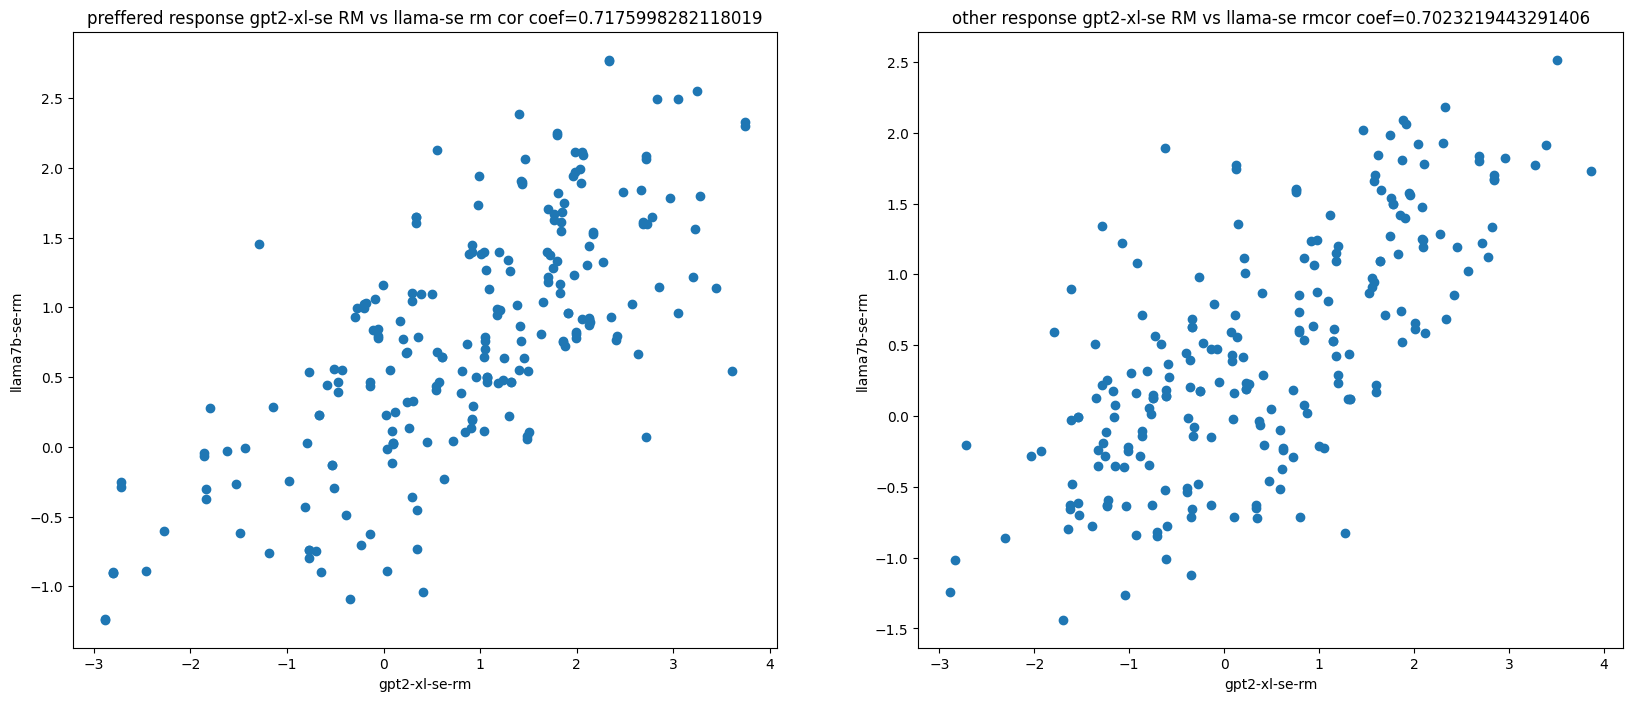

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))  # Width and height in inches

plt.subplot(1, 2, 1)
plt.title(f"preffered response gpt2-xl-se RM vs llama-se rm cor coef={np.corrcoef(gpt2_rewards_js, llama_rewards_js)[0, 1]}")
plt.scatter(gpt2_rewards_js, llama_rewards_js)
plt.xlabel("gpt2-xl-se-rm")
plt.ylabel("llama7b-se-rm")

plt.subplot(1, 2, 2)
plt.title(f"other response gpt2-xl-se RM vs llama-se rmcor coef={np.corrcoef(gpt2_rewards_ks, llama_rewards_ks)[0, 1]}")
plt.scatter(gpt2_rewards_ks, llama_rewards_ks)
plt.xlabel("gpt2-xl-se-rm")
plt.ylabel("llama7b-se-rm")
